In [1]:
import numpy as np
import tensorflow as tf
from collections import deque
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [2]:
class Actor:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.hidden_dim = 32
        self.model = self._build_model()
        def adv_baseline_loss(y_true, y_pred):
            # Calculate the advantage
            advantage = y_true - y_pred

            # Calculate the policy loss
            policy_loss = -tf.math.log(y_pred) * tf.stop_gradient(advantage)

            # Calculate the baseline loss
            baseline_loss = tf.reduce_mean(tf.square(advantage))

            # Calculate the total loss
            total_loss = policy_loss + baseline_loss

            return total_loss
        
        self.model.compile(loss=adv_baseline_loss, optimizer=Adam(learning_rate=self.lr))

    def _build_model(self):
        model = Sequential()
        model.add(Dense(self.hidden_dim, input_shape=(self.input_dim,), activation="relu"))
        model.add(Dense(self.hidden_dim, activation="relu"))
        model.add(Dense(self.output_dim, activation="softmax"))
        return model

    def act(self, state):
        probs = self.model.predict(state)[0]
        action = np.random.choice(range(self.output_dim), p=probs)
        return action

    def optimizer(self):
        # Advantage function (REINFORCE with baseline)
        state_pl = self.model.input
        action_onehot_pl = Input(name="action_onehot", shape=(None, self.output_dim))
        adv_pl = Input(name="advantage", shape=(None,))

        pi_pl = self.model.output
        pi_vec = tf.reduce_sum(action_onehot_pl * pi_pl, axis=1)
        loss_vec = -tf.math.log(pi_vec) * tf.stop_gradient(adv_pl)
        loss = tf.reduce_mean(loss_vec)

        opt = Adam(learning_rate=self.lr)


In [3]:
class Critic:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.hidden_dim = 32
        self.model = self._build_model()
        self.train = self.model.compile(loss='mse', optimizer=Adam(learning_rate=self.lr))

    def _build_model(self):
        model = Sequential()
        model.add(Dense(self.hidden_dim, input_shape=(self.input_dim,), activation="relu"))
        model.add(Dense(self.hidden_dim, activation="relu"))
        model.add(Dense(1, activation="linear"))
        return model

    def train(self, S, G):
        self.model.train_on_batch([S, G])

In [4]:
class Agent:
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = 16
        self.lr = 0.001
        self.gamma = 0.99

        self.states = deque(maxlen=4096)  # Experience replay memory
        self.actions = deque(maxlen=4096)
        self.rewards = deque(maxlen=4096)

        self.actor = Actor(input_dim, output_dim, self.lr)
        self.critic = Critic(input_dim, output_dim, self.lr)

    def act(self, state):
        probs = self.actor.model.predict(state)[0]
        print(f"Shape of probs: {probs.shape}")  # Debug print statement
        probs = np.squeeze(probs)  # Ensure probs is 1-dimensional
        action = np.random.choice(range(self.output_dim), p=probs)
        return action

    def remember(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def learn(self):
        # Sample from memory
        S = np.array(self.states)
        A = np.array(self.actions)
        R = np.array(self.rewards)

        # One-hot encode actions
        A_onehot = to_categorical(A, self.output_dim)

        # Find discounted returns and advantages
        G = self.find_discounted_return(R)
        V = self.critic.model.predict(S)
        V = np.reshape(V, len(V))
        Adv = G - V

        # Train actor and critic
        self.actor.train([S, A_onehot, Adv])
        self.critic.train([S, G])

        # Clear memory (optional for experience replay)
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()

    def find_discounted_return(self, R):
        R_discounted = np.zeros_like(R)
        running_total = 0
        for t in reversed(range(len(R_discounted))):
            running_total = running_total * self.gamma + R[t]
            R_discounted[t] = running_total
        R_discounted -= np.mean(R_discounted)
        R_discounted /= np.std(R_discounted)
        return R_discounted

# Training

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from environment.models.simple_control_fixed import SimpleControlledFixedEnv

In [6]:
env = SimpleControlledFixedEnv()
env.latency = 0
env.fixed_error_ctrl_alice = [np.pi/2, 0, 0, 0]
env.fixed_error_ctrl_bob = [0, 0, 0, 0]
env.fixed_error_ctrl_pump = [0, 0, 0, 0]
env.fixed_errors_flags = [True, True, True, True,
                          True, True, True, True,
                          True, True, True, True,]
env.delta_t = 1
env.max_t = 100

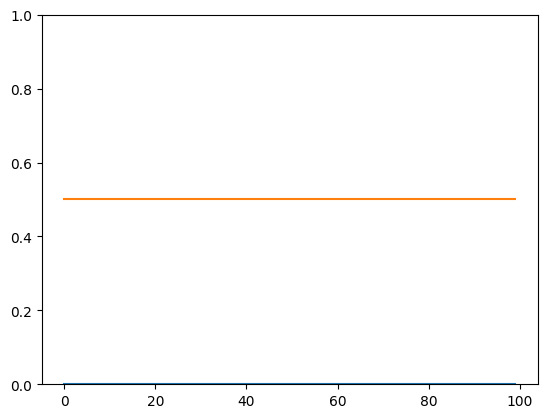

In [7]:
env.reset()
# print(env.get_done())
done = False
while not done:
    _, _, done = env.step()
    # print(done)

# print(env.get_done())
import matplotlib.pyplot as plt
plt.ylim(0, 1)
# print(env.get_qber())
plt.plot(env.get_qber())

In [8]:
from tqdm import trange

input_dim = 2
output_dim = 3
agent = Agent(input_dim, output_dim)

EPISODES = trange(100, desc='Episode: ', leave=True)
scores_baseline = []
for e in EPISODES:
    state, _ = env.reset()
    reward_sum = 0
    done = False
    while not done:
        # print(f"State shape before act: {state}") 
        state = tf.convert_to_tensor(state, dtype=tf.float32)
        state = tf.expand_dims(state, axis=0)  # Add batch dimension
        action = agent.act(state)
        next_state, reward, done = env.step(a_alice=[action, 0, 0, 0])
        agent.remember(state, action, reward)
        state = next_state
        reward_sum += reward
    agent.learn()
    scores_baseline.append(reward_sum)
    # if e % 100 == 0:
    #     print('episode, reward = {}, {}'.format(e,reward_sum))
plt.plot(scores_baseline)
plt.legend('reward')

c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Episode:   0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Shape of probs: (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Shape of probs: (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Shape of probs: (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Shape of probs: (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Shape of probs: (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Shape of probs: (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Shape of probs: (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Shape of probs: (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Shape of probs: (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Shape of probs: (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Shape of probs: (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Shape of probs: (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Shape of probs: (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Shape of probs: (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Shape of probs: (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Shape of probs: (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Shape of probs: (3

Episode:   0%|          | 0/100 [00:07<?, ?it/s]


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 1, 2), dtype=float32). Expected shape (None, 2), but input has incompatible shape (32, 1, 2)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 1, 2), dtype=float32)
  • training=False
  • mask=None